In [1]:
# import packages
import numpy as np
import random

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import os

import math
import tensorly as ts

In [2]:
# set constants for background generation
L = 0.40 # length
H = 0.40 # height
dx = 0.0025
dy = 0.0025
tmax = 100
dt = .10 # change in time
epsilon = 0.0001

clean_save_path = "./samples/clean"

if (not os.path.exists(clean_save_path)):
        os.makedirs(clean_save_path)

anomaly_save_path = "./samples/anomaly"

if (not os.path.exists(anomaly_save_path)):
        os.makedirs(anomaly_save_path)

In [3]:
# what is the Fo number?
NN = 10

# generate the random noise values
domainalp = np.array([])
for i in range(NN):
    domainalp = np.append(domainalp, 0.5e-5 + 1e-5 * random.random())

# CENTERT = [] # NN x 1
# AVET = [] # NN x 1

# # list of simulated data matrices
# SimulateData = [] # NN x 10
# SimulateDataNoNoise = []

In [4]:
# constants for anomaly generation
dI = 1.3 # intensity difference
namin = 3 # min number of anomalies
namax = 10 # max number anomalies

rmin = 3 # min radius of anomaly
rmax = 10 # max radius of anomaly

In [5]:
def dist(x1, y1, x2, y2):
    return math.sqrt(math.pow((x2 - x1), 2) + math.pow(y2 - y1, 2))

# overlay a set of anomalies on the matrix T
def generate_anomalies(T, nx, ny):
    # number of anomalies
    na = random.randint(namin, namax) # any random number of anomalies between namin and namax

    for a in range(na): 
        # generate location
        x = random.randint(0, nx - 1)
        y = random.randint(0, ny - 1)

        # generate radius
        r = random.randint(rmin, rmax)

        # alter values within r of the central axis 
        lower_x = max(x - r, 0)
        upper_x = min(x + r, nx - 1)

        lower_y = max(y - r, 0)
        upper_y = min(y + r, ny - 1)

        for i in range(lower_x, upper_x + 1):
            for j in range(lower_y, upper_y + 1):
                if (dist(x, y, i, j) <= r):
                    T[i][j] = T[i][j] * dI
                else:
                    continue
        
    return T
    

In [6]:
def generate_images():
    # generate and save images
    for iN in range(NN):

        clean_file_path = os.path.join(clean_save_path, str(iN))
        anomaly_file_path = os.path.join(anomaly_save_path, str(iN))

        # generate the noise values
        r_x = domainalp[iN] * dt/(pow(dx, 2))
        r_y = domainalp[iN] * dt/(pow(dy, 2))
        fo = r_x + r_y

        # what does this condition mean? no convergence?
        if fo > 0.5000:
            raise Exception("Numerical stability requires Fo <= 1/2")
            exit()

        # we create a matrix of values
        nx = (int) (L / dx + 1)
        ny = (int) (H / dx + 1)

        grid = np.empty((nx, ny))

        # find center
        ic = (int) ((nx - 1) / 2) # no plus one, index starts at 0
        jc = (int) ((ny - 1) / 2)

        # set boundary conditions
        T = np.zeros((nx, ny))

        # column 0
        T[:,0] = 1

        # column ny - 1
        T[:, ny-1] = 1

        # row 0
        T[0, :] = 1

        # row nx - 1
        T[nx - 1, :] = 1

        # I had difficulty telling what this step does?? are they not 0 and 1?)
        Tmin = np.min(np.min(T)) 
        Tmax = np.max(np.max(T)) 
        
        # iterative component
        n = 0 # index

        nmax = (int) (tmax/dt)

        while n < nmax:
                n = n + 1

                T_n = T
                T_anomalies = T

                # define temperature values
                for j in range(1, nx - 1):
                    for i in range(1, nx - 1):
                        T[j][i]= T_n[j][i] + r_x*(T_n[j][i+1]-2*T_n[j][i]+T_n[j][i-1]) + r_y*(T_n[j+1][i]-2*T_n[j][i]+T_n[j-1][i])

                a = T.shape
                NoiseT = T + 0.1 * np.random.rand(a[0], a[1])

        print("Saving file " + str(iN) + " of " + str(NN))

        # save images w/out anomalies
        plt.imshow(NoiseT, cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig(clean_file_path, bbox_inches='tight', pad_inches=0)
        
        # save images w/ anomalies
        NoiseT = generate_anomalies(NoiseT, nx, ny)

        plt.imshow(NoiseT, cmap='hot', interpolation='nearest')
        plt.axis('off')
        plt.savefig(anomaly_file_path, bbox_inches='tight', pad_inches=0)

Saving file 0 of 10
Saving file 1 of 10
Saving file 2 of 10
Saving file 3 of 10
Saving file 4 of 10
Saving file 5 of 10
Saving file 6 of 10
Saving file 7 of 10
Saving file 8 of 10
Saving file 9 of 10


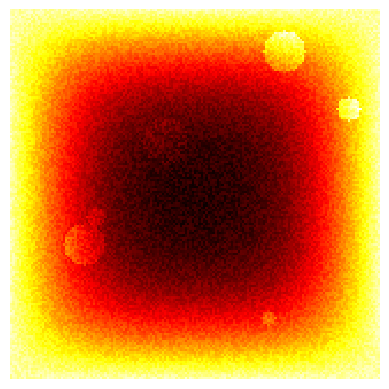

In [7]:
generate_images()

## Tucker Decomposition
References: 
- Tensor Decompositions and Applications by Tamara G. Kolda and Brett W. Bader, SIAM Review, September 2009, Vol. 51, No. 3 (September 2009), pp. 455-500
- Understanding the Tucker decomposition, and compressing tensor-valued data (with R code) by Alexej Gossmann, https://www.alexejgossmann.com/tensor_decomposition_tucker/, April 5, 2017
- Higher-Order Singular Value Decomposition: Theory and an Application by Göran Bergqvist and Erik G. Larsson, https://www.diva-portal.org/smash/get/diva2:316227/FULLTEXT01.pdf, 2009
- Singular Value Decomposition for High-dimensional High-order Data by Anru Zhang, https://csml.princeton.edu/sites/g/files/toruqf911/files/resource-links/zhang2018princeton.pdf, May 14, 2018

In [43]:
# Melody attempts to code HOSVD 
# no guarantee this works?? 
def HOSVD(T):
    # calculate rank of T?? Is this needed?
    N = T.shape[0]

    A = np.array([])

    # for n = 1 to N:
    for n in range(N):
        # calculate single value decomposition (SVD) for nth layer of T
        # U, S, Vh = np.linalg.svd(T[n])
        U, S, Vh = np.linalg.svd(T[n])
        
        # A[n] <- U
        A.append(U)

    # # calculate G
    # G <- T x1 A[1]^T x2 ... xn A[N]^T
    return # G, A

In [63]:
# re-define constants for testing
NN = 1

# set constants for background generation
L = 0.05 # length
H = 0.05 # height
dx = 0.0025
dy = 0.0025
tmax = 100
dt = .10 # change in time
epsilon = 0.0001

save_path = "./ANOMALIES_decomposition_samples"

# if (not os.path.exists(save_path)):
#         os.makedirs(save_path)
        
# constants for anomaly generation
dI = 1.3 # intensity difference
namin = 3 # min number of anomalies
namax = 10 # max number anomalies

rmin = 3 # min radius of anomaly
rmax = 10 # max radius of anomaly

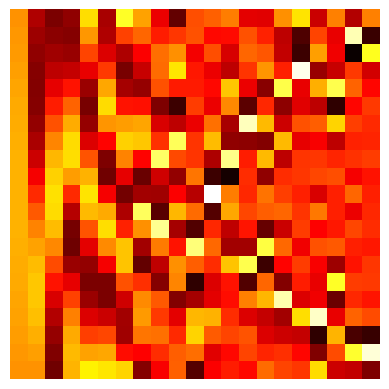

In [65]:
# generate np arrays representing images
# apply tucker decomposition from TensorLy
for iN in range(NN):

    directory_path = os.path.join(save_path, str(iN))

    if (not os.path.exists(directory_path)):
        os.makedirs(directory_path)

    A = []
    
    file_path = os.path.join(save_path, str(iN))

    # generate the noise values
    r_x = domainalp[iN] * dt/(pow(dx, 2))
    r_y = domainalp[iN] * dt/(pow(dy, 2))
    fo = r_x + r_y

    # what does this condition mean? no convergence?
    if fo > 0.5000:
        raise Exception("Numerical stability requires Fo <= 1/2")
        exit()

    # we create a matrix of values
    nx = (int) (L / dx + 1)
    ny = (int) (H / dx + 1)

    grid = np.empty((nx, ny))

    # find center
    ic = (int) ((nx - 1) / 2) # no plus one, index starts at 0
    jc = (int) ((ny - 1) / 2)

    # set boundary conditions
    T = np.zeros((nx, ny))

    # column 0
    T[:,0] = 1

    # column ny - 1
    T[:, ny-1] = 1

    # row 0
    T[0, :] = 1

    # row nx - 1
    T[nx - 1, :] = 1

    # I had difficulty telling what this step does?? are they not 0 and 1?)
    Tmin = np.min(np.min(T)) 
    Tmax = np.max(np.max(T)) 
    
    # iterative component
    n = 0 # index

    nmax = (int) (tmax/dt)

    while n < nmax:
            n = n + 1

            T_n = T
            T_anomalies = T

            # define temperature values
            for j in range(1, nx - 1):
                for i in range(1, nx - 1):
                     T[j][i]= T_n[j][i] + r_x*(T_n[j][i+1]-2*T_n[j][i]+T_n[j][i-1]) + r_y*(T_n[j+1][i]-2*T_n[j][i]+T_n[j-1][i])

            a = T.shape
            NoiseT = T + 0.1 * np.random.rand(a[0], a[1])

            NoiseT = generate_anomalies(NoiseT, nx, ny)

            # store the array
            A.append(NoiseT)

    A = np.array(A)

    # calculate rank for each layer
    ranks = np.linalg.matrix_rank(A)

    # component Tucker decomposition
    core, factors = ts.decomposition.tucker(A, ranks)

    plt.axis('off')

    for i in range(21):
         # define save path for core slices
         file_path = os.path.join(directory_path, "core" + str(i))

         plt.imshow(core[i], cmap='hot', interpolation='nearest')
         plt.savefig(file_path, bbox_inches='tight', pad_inches=0)

    for i in range(3):
         # define save path for core slices
         file_path = os.path.join(directory_path, "factors" + str(i))

         plt.imshow(factors[i], cmap='hot', interpolation='nearest')
         plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
            